# 좌표 데이터와 행정구역을 이용한 공간 분석 및 시각화 실습
도시공원 CSV 파일의 좌표 속성과 시군구 행정구역 SHP을 이용하여 시군구별 단계구분도를 직접 만들어 봅시다.

## 데이터
- 공공데이터포털에서 전국도시공원정보표준데이터(https://www.data.go.kr/data/15012890/standard.do) csv 파일을 다운로드    
- 국가공간정보포털에서 행정구역시군구_경계(http://data.nsdi.go.kr/dataset/15144) 중 서울 데이터를 다운로드   
  : 국가공간정보포털은 로그인(회원가입) 필요  
  : 회원가입이 안된 경우, http://www.gisdeveloper.co.kr/?p=2332의 시군구 행정구역도 사용 가능 (단, 좌표계는 다를 수 있음) 

## 분석 과정
1. 행정구역을 면형 공간데이터프레임으로 로딩   
 1.1 공간데이터 로딩  
 1.2 데이터프레임 속성 검토 (한글 확인)  
 1.3 기초 공간시각화 등을 이용한 이상치/결측치 검토   
 1.4 좌표계를 확인 (기준 EPSG:5179)  
   

2. 도시공원 csv를 데이터프레임으로 로딩하고, 관리기관명 속성을 이용하여 서울시 데이터만 추출  
 2.1 데이터 로딩   
 2.2 데이터프레임 기초 검토 (항목, 한글 속성 등)
 2.3 서울시만 추출   


3. 도시공원(2 결과)의 위도, 경도 속성을 이용하여 점형 공간데이터프레임을 생성     

4. 도시공원 공간데이터(3 결과)의 좌표계를 행정구역에 맞게 좌표계를 변환     

5. 시군구 행정구역과 도시공원을 공간조인    

6. 도시공원의 "공원면적" 속성을 시군구별로 합산하여 배경지도 위에 내추럴 브레이크 방식의 단계구분도로 공간시각화 


## 6번 결과 이미지 및 데이터 파일을 제출
- 분석환경의 문제로 내추럴 브레이크 적용이 안될 경우, 그 부분만 제외하고 진행
- 선착순.....

In [1]:
import geopandas as gpd
import pandas as pd
# from fiona.crs import from_epsg # 좌표변환 
import contextily as ctx 

c:\Users\LX\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\LX\AppData\Local\Temp\ipykernel_5824\653850714.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smoo

In [3]:
# 행정구역 로딩
gdf = gpd.read_file('./data/shp/LARD_ADM_SECT_SGG_11.shp', encoding='cp949')
gdf.head()

ADM_SECT_C SGG_NM  SGG_OID COL_ADM_SE  GID  \
0      11740    강동구      337      11740  127   
1      11710    송파구     1969      11710  128   
2      11680    강남구       33      11680  129   
3      11650    서초구       33      11650  130   
4      11620    관악구       33      11620  131   

                                            geometry  
0  POLYGON ((969713.132 1948846.288, 969692.451 1...  
1  POLYGON ((968640.372 1944982.492, 968640.957 1...  
2  POLYGON ((958696.114 1948605.678, 959195.920 1...  
3  POLYGON ((958117.753 1940073.855, 958118.398 1...  
4  POLYGON ((949321.250 1944035.054, 949323.256 1...

<Axes: >

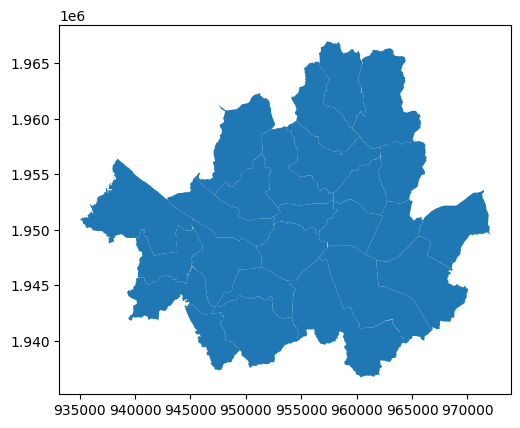

In [4]:
gdf.plot()

In [5]:
gdf.crs

<Projected CRS: EPSG:5179>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
# 도시공원 데이터 로딩
df = pd.read_csv('./data/csv/전국도시공원정보표준데이터.csv', encoding='cp949')
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18146 entries, 0 to 18145
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   관리번호          18146 non-null  object 
 1   공원명           18146 non-null  object 
 2   공원구분          18146 non-null  object 
 3   소재지도로명주소      6476 non-null   object 
 4   소재지지번주소       17340 non-null  object 
 5   위도            17803 non-null  float64
 6   경도            17800 non-null  float64
 7   공원면적          18146 non-null  float64
 8   공원보유시설(운동시설)  4941 non-null   object 
 9   공원보유시설(유희시설)  6627 non-null   object 
 10  공원보유시설(편익시설)  5307 non-null   object 
 11  공원보유시설(교양시설)  1117 non-null   object 
 12  공원보유시설(기타시설)  2947 non-null   object 
 13  지정고시일         15544 non-null  object 
 14  관리기관명         16998 non-null  object 
 15  전화번호          16609 non-null  object 
 16  데이터기준일자       18146 non-null  object 
 17  제공기관코드        18146 non-null  object 
 18  제공기관명         18146 non-nu

관리번호  공원명   공원구분 소재지도로명주소              소재지지번주소         위도  \
0  29200-00068  다모아  어린이공원      NaN  광주광역시 광산구 월곡동 520-1  35.170911   
1  29200-00069   햇살  어린이공원      NaN    광주광역시 광산구 월곡동 503  35.174005   

           경도    공원면적 공원보유시설(운동시설) 공원보유시설(유희시설) 공원보유시설(편익시설) 공원보유시설(교양시설)  \
0  126.806951  2231.0          NaN          NaN          NaN          NaN   
1  126.806878  1689.4          NaN          NaN          NaN          NaN   

  공원보유시설(기타시설)       지정고시일      관리기관명          전화번호     데이터기준일자   제공기관코드  \
0          NaN  1990-06-30  광주광역시 광산구  062-960-8712  2020-07-08  6290000   
1          NaN  1990-06-30  광주광역시 광산구  062-960-8712  2020-07-08  6290000   

   제공기관명  
0  광주광역시  
1  광주광역시

In [9]:
df2 = df[ df.제공기관명.str.contains('서울') ].reset_index()
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1871 entries, 0 to 1870
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         1871 non-null   int64  
 1   관리번호          1871 non-null   object 
 2   공원명           1871 non-null   object 
 3   공원구분          1871 non-null   object 
 4   소재지도로명주소      509 non-null    object 
 5   소재지지번주소       1853 non-null   object 
 6   위도            1801 non-null   float64
 7   경도            1798 non-null   float64
 8   공원면적          1871 non-null   float64
 9   공원보유시설(운동시설)  453 non-null    object 
 10  공원보유시설(유희시설)  618 non-null    object 
 11  공원보유시설(편익시설)  567 non-null    object 
 12  공원보유시설(교양시설)  89 non-null     object 
 13  공원보유시설(기타시설)  144 non-null    object 
 14  지정고시일         1077 non-null   object 
 15  관리기관명         1495 non-null   object 
 16  전화번호          1578 non-null   object 
 17  데이터기준일자       1871 non-null   object 
 18  제공기관코드        1871 non-null 

index         관리번호       공원명   공원구분 소재지도로명주소               소재지지번주소  \
0    170  11680-00061      학동공원  어린이공원      NaN  서울특별시 강남구 논현동 263-23   
1    171  11680-00062  신사은행나무공원  어린이공원      NaN     서울특별시 강남구 신사동 558   
2    172  11680-00063    신사목련공원  어린이공원      NaN  서울특별시 강남구 신사동 567-37   
3    173  11680-00064   신사무궁화공원  어린이공원      NaN   서울특별시 강남구 신사동 625-5   
4    174  11680-00065    신사까치공원  어린이공원      NaN     서울특별시 강남구 신사동 597   

          위도          경도    공원면적 공원보유시설(운동시설) 공원보유시설(유희시설) 공원보유시설(편익시설)  \
0  37.511646  127.038764  1498.5          NaN          NaN          NaN   
1  37.521114  127.021627  1240.1          NaN          NaN          NaN   
2  37.522898  127.017064  1001.1          NaN          NaN          NaN   
3  37.524131         NaN  1641.8          NaN          NaN          NaN   
4        NaN  127.020466   992.9          NaN          NaN          NaN   

  공원보유시설(교양시설) 공원보유시설(기타시설) 지정고시일 관리기관명          전화번호     데이터기준일자   제공기관코드  \
0          NaN          NaN   NaN   NaN  02-3423-6247  2020-08-27  3220000   
1          NaN          NaN   NaN   NaN  02-3423-6247  2020-08-27  3220000   
2          NaN          NaN   NaN   NaN  02-3423-6247  2020-08-27  3220000   
3          NaN          NaN   NaN   NaN  02-3423-6247  2020-08-27  3220000   
4          NaN          NaN   NaN   NaN  02-3423-6247  2020-08-27  3220000   

       제공기관명  
0  서울특별시 강남구  
1  서울특별시 강남구  
2  서울특별시 강남구  
3  서울특별시 강남구  
4  서울특별시 강남구

In [15]:
df2 = df2[ (df2['경도'] > 0) & (df2['위도'] > 30)   ]

In [16]:
df2_geom = gpd.points_from_xy(df2.경도, df2.위도)
columns = df2.columns
gdf_park4326 = gpd.GeoDataFrame(df2[columns], geometry=df2_geom, crs="epsg:4326" )
gdf_park4326.head()

index         관리번호       공원명   공원구분 소재지도로명주소               소재지지번주소  \
0    170  11680-00061      학동공원  어린이공원      NaN  서울특별시 강남구 논현동 263-23   
1    171  11680-00062  신사은행나무공원  어린이공원      NaN     서울특별시 강남구 신사동 558   
2    172  11680-00063    신사목련공원  어린이공원      NaN  서울특별시 강남구 신사동 567-37   
5    175  11680-00066   신사개나리공원  어린이공원      NaN   서울특별시 강남구 신사동 609-2   
6    176  11680-00067   압구정목련공원  어린이공원      NaN    서울특별시 강남구 압구정동 466   

          위도          경도    공원면적 공원보유시설(운동시설)  ... 공원보유시설(편익시설) 공원보유시설(교양시설)  \
0  37.511646  127.038764  1498.5          NaN  ...          NaN          NaN   
1  37.521114  127.021627  1240.1          NaN  ...          NaN          NaN   
2  37.522898  127.017064  1001.1          NaN  ...          NaN          NaN   
5  37.526208  127.027304   991.3          NaN  ...          NaN          NaN   
6  37.532685  127.032209  2027.2          NaN  ...          NaN          NaN   

  공원보유시설(기타시설) 지정고시일 관리기관명          전화번호     데이터기준일자   제공기관코드      제공기관명  \
0          NaN   NaN   NaN  02-3423-6247  2020-08-27  3220000  서울특별시 강남구   
1          NaN   NaN   NaN  02-3423-6247  2020-08-27  3220000  서울특별시 강남구   
2          NaN   NaN   NaN  02-3423-6247  2020-08-27  3220000  서울특별시 강남구   
5          NaN   NaN   NaN  02-3423-6247  2020-08-27  3220000  서울특별시 강남구   
6          NaN   NaN   NaN  02-3423-6247  2020-08-27  3220000  서울특별시 강남구   

                     geometry  
0  POINT (127.03876 37.51165)  
1  POINT (127.02163 37.52111)  
2  POINT (127.01706 37.52290)  
5  POINT (127.02730 37.52621)  
6  POINT (127.03221 37.53269)  

[5 rows x 21 columns]

<Axes: >

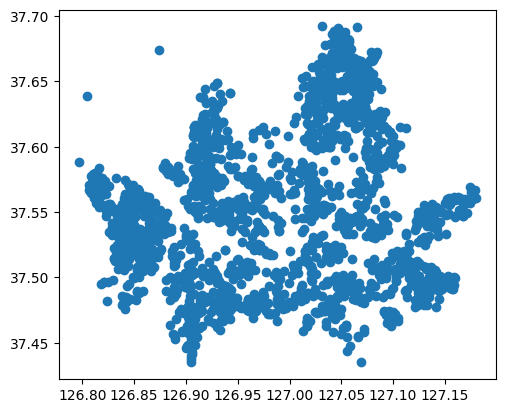

In [17]:
gdf_park4326.plot()

In [18]:
gdf_park5179 = gdf_park4326.to_crs(epsg=5179)

In [19]:
gdf_sjoin = gpd.sjoin(gdf, gdf_park5179)
gdf_sjoin.head()

ADM_SECT_C SGG_NM  SGG_OID COL_ADM_SE  GID  \
0      11740    강동구      337      11740  127   
0      11740    강동구      337      11740  127   
0      11740    강동구      337      11740  127   
0      11740    강동구      337      11740  127   
0      11740    강동구      337      11740  127   

                                            geometry  index_right  index  \
0  POLYGON ((969713.132 1948846.288, 969692.451 1...          131    442   
0  POLYGON ((969713.132 1948846.288, 969692.451 1...          130    441   
0  POLYGON ((969713.132 1948846.288, 969692.451 1...          132    443   
0  POLYGON ((969713.132 1948846.288, 969692.451 1...          129    440   
0  POLYGON ((969713.132 1948846.288, 969692.451 1...          139    728   

          관리번호   공원명  ...                공원보유시설(유희시설) 공원보유시설(편익시설)  \
0  11740-00008  보람공원  ...             조합놀이대, 그네, 흔들놀이          NaN   
0  11740-00007  선린공원  ...            조합놀이대, 그네, 모래놀이터          NaN   
0  11740-00009  안말공원  ...             조합놀이대, 그네, 흔들놀이          NaN   
0  11740-00006  성안공원  ...      조합놀이대, 그네, 흔들놀이, 모래놀이터          음수대   
0  11740-00057  둔촌공원  ...  조합놀이대, 그네, 시소, 흔들놀이, 모래놀이터          음수대   

  공원보유시설(교양시설)  공원보유시설(기타시설)       지정고시일       관리기관명          전화번호  \
0          NaN           NaN  1972-11-06  서울특별시 강동구청  02-3425-6440   
0          NaN           NaN  1972-11-06  서울특별시 강동구청  02-3425-6440   
0          NaN           NaN  1972-11-06  서울특별시 강동구청  02-3425-6440   
0          NaN           NaN  1972-11-06  서울특별시 강동구청  02-3425-6440   
0          NaN           NaN  1990-02-21  서울특별시 강동구청  02-3425-6440   

      데이터기준일자   제공기관코드      제공기관명  
0  2020-09-11  3240000  서울특별시 강동구  
0  2020-09-11  3240000  서울특별시 강동구  
0  2020-09-11  3240000  서울특별시 강동구  
0  2020-09-11  3240000  서울특별시 강동구  
0  2020-09-11  3240000  서울특별시 강동구  

[5 rows x 27 columns]

In [20]:
df_parkarea = gdf_sjoin.groupby(['SGG_NM'])['공원면적'].sum().reset_index()
df_parkarea.head()

SGG_NM       공원면적
0    강남구  1634394.9
1    강동구  1926837.3
2    강북구  1443604.5
3    강서구  3410586.5
4    관악구   451304.9

In [21]:
gdf3 = pd.merge(gdf, df_parkarea, on='SGG_NM', how='left')
gdf3.head()

ADM_SECT_C SGG_NM  SGG_OID COL_ADM_SE  GID  \
0      11740    강동구      337      11740  127   
1      11710    송파구     1969      11710  128   
2      11680    강남구       33      11680  129   
3      11650    서초구       33      11650  130   
4      11620    관악구       33      11620  131   

                                            geometry       공원면적  
0  POLYGON ((969713.132 1948846.288, 969692.451 1...  1926837.3  
1  POLYGON ((968640.372 1944982.492, 968640.957 1...  3561295.7  
2  POLYGON ((958696.114 1948605.678, 959195.920 1...  1634394.9  
3  POLYGON ((958117.753 1940073.855, 958118.398 1...  1663484.3  
4  POLYGON ((949321.250 1944035.054, 949323.256 1...   451304.9

In [22]:
gdf3857 = gdf3.to_crs(epsg=3857)

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid') #whitegrid, dark, white, ticks
mpl.rc('font', family='NanumGothic') #한글 폰트 적용시
plt.rcParams["figure.figsize"] = (16,4.5) #차트 사이즈

<ipython-input-57-83531a7721ea>:2: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  ctx.add_basemap(ax, source=ctx.sources.ST_TERRAIN)


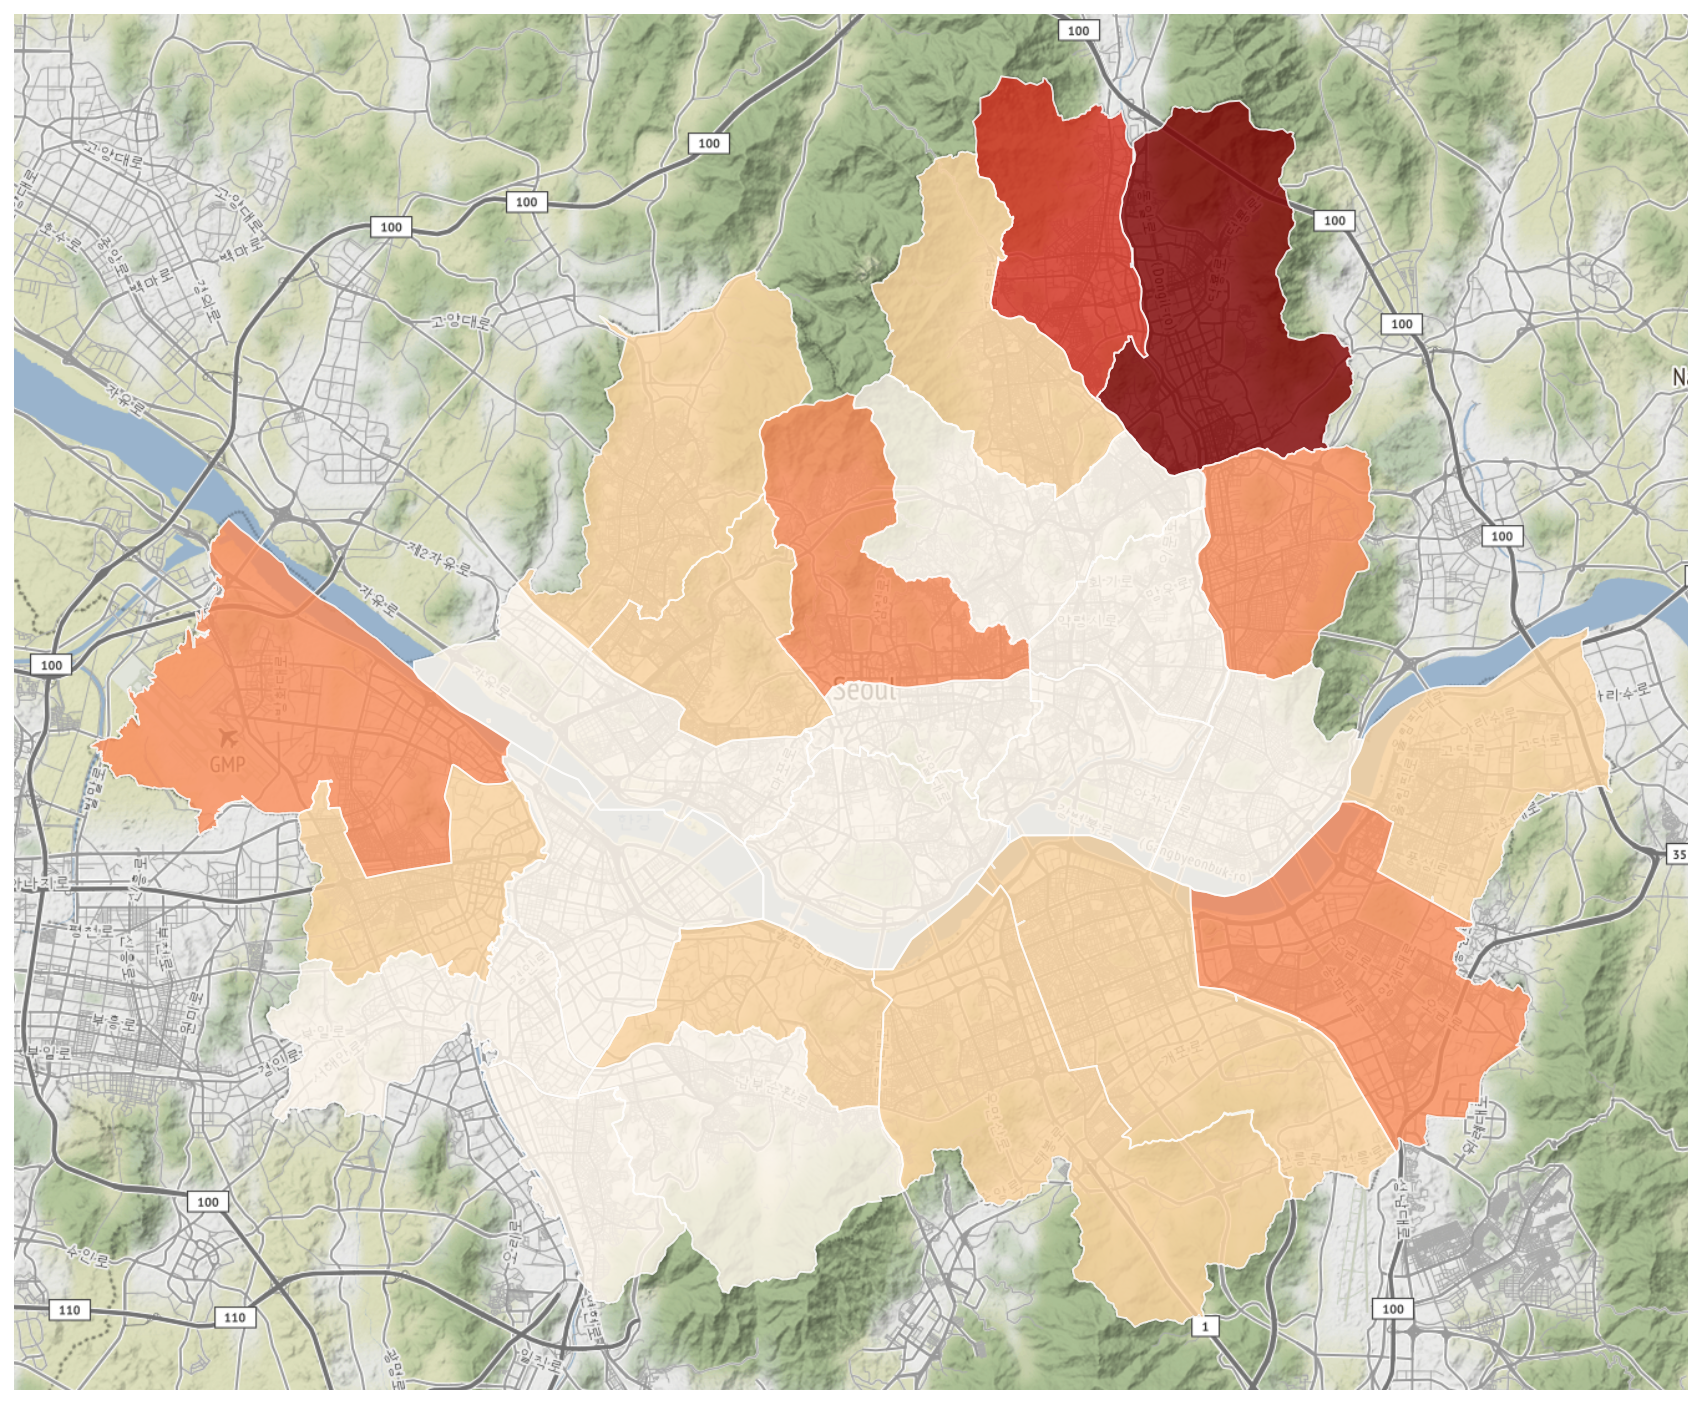

In [57]:
ax = gdf3857.plot(column='공원면적', scheme='Fisher_Jenks', k=5, cmap='OrRd', figsize=(15, 15), alpha=0.8)
ctx.add_basemap(ax, source=ctx.sources.ST_TERRAIN)  #ctx.sources.ST_TONER_LITE
ax.set_axis_off()
plt.show()